## Binance API Proof of Concept

You will need to do a pip install of the following packages to store your crypto balance from the API to a pandas df 
- pandas 
- python-binance
- json 

In [1]:
import pandas as pd
from binance.client import Client
import json

In [2]:
# Connect to the Binance API  

with open("config/config.json") as config_file:
    config_dict = json.load(config_file)

api_key = config_dict.get("api_key")
api_secret = config_dict.get("api_secret")

client = Client(api_key, api_secret)


In [3]:
info = client.get_account()  # Getting account info

#Save the crypto assets that the user holds into a list 
list_assets= []
for item in info['balances']:
    if float(item['free']) > 0:
        print("Retrieving asset:", item['asset'])
        list_assets+= [item['asset']]

for asset in list_assets:
    balance = client.get_asset_balance(asset)
    print("The amount of ",asset,"=", balance['free'])
    

Retrieving asset: BNB
The amount of  BNB = 0.06000000


In [4]:
# Initialize an empty dataframe
df_crypto_assets = pd.DataFrame(columns=['Asset', 'Quantity', 'Value_in_EUR'])

# First, get the current EUR/USDT exchange rate
try:
    eur_usdt_info = client.get_symbol_ticker(symbol='EURUSDT')
    eur_usdt_price = float(eur_usdt_info['price'])
    print("The current price of 1 EUR in USDT =", eur_usdt_price)
except:
    print("Price info for EUR not found. It might not be traded against USDT.")
    eur_usdt_price = None

# Get the price of each asset in relation to EUR
for asset in list_assets:
    balance = client.get_asset_balance(asset)
    print("The amount of", asset, "=", balance['free'])
    
    try:
        price_info = client.get_symbol_ticker(symbol=f'{asset}USDT')
        usdt_price = float(price_info['price'])
        print("The current price of", asset, "in USDT =", round(usdt_price,2))

        if eur_usdt_price:
            eur_price = usdt_price / eur_usdt_price
            print("The current price of", asset, "in EUR =", round(eur_price,2))
            
            # Calculate total value in EUR
            total_value_in_eur = eur_price * float(balance['free'])
            total_value_in_eur
            print("Your net holdings in", asset, "in EUR =", round(total_value_in_eur,2))
            # Append to the dataframe
            df_crypto_assets = df_crypto_assets.append({
                'Asset': asset, 
                'Quantity': balance['free'], 
                'Value_in_EUR': total_value_in_eur}, 
                ignore_index=True)
        else:
            print("Could not convert the price of", asset, "to EUR due to lack of EUR/USDT price info.")
    except:
        print("Price info for", asset, "not found. It might not be traded against USDT.")

print(df_crypto_assets)

The current price of 1 EUR in USDT = 1.0932
The amount of BNB = 0.06000000
The current price of BNB in USDT = 244.5
The current price of BNB in EUR = 223.66
Your net holdings in BNB in EUR = 13.42
  Asset    Quantity Value_in_EUR
0   BNB  0.06000000    13.419319


/var/folders/l1/rsdlp3115cb17fddgp9zvn5w0000gn/T/ipykernel_95969/3816793892.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_crypto_assets = df_crypto_assets.append({


Real-Data as a Proof of Concept

In [5]:
df_crypto_assets

,Asset,Quantity,Value_in_EUR
0,BNB,0.06000000,13.419319


## Creating a random crypto portfolio for MVP

In [6]:
import numpy as np

In [7]:
np.random.seed(42)

# Initialize the list of assets
list_assets = ['BNB', 'ETH', 'BTC', 'DOGE']

# Initialize an empty dataframe to store asset data
df_crypto_assets = pd.DataFrame(columns=['Asset', 'Quantity', 'Value_in_EUR', 'Price_in_EUR'])

# Get the current EUR/USDT exchange rate
try:
    eur_usdt_info = client.get_symbol_ticker(symbol='EURUSDT')
    eur_usdt_price = float(eur_usdt_info['price'])
    print("The current price of 1 EUR in USDT =", eur_usdt_price)
except:
    print("Price info for EUR not found. It might not be traded against USDT.")
    eur_usdt_price = None

# Get the price of each asset in relation to EUR
for asset in list_assets:
    try:
        price_info = client.get_symbol_ticker(symbol=f'{asset}USDT')
        usdt_price = float(price_info['price'])
        print("The current price of", asset, "in USDT =", usdt_price)

        if eur_usdt_price:
            eur_price = usdt_price / eur_usdt_price
            print("The current price of", asset, "in EUR =", eur_price)
            
            # Append asset and price to the dataframe
            df_crypto_assets = df_crypto_assets.append({
                'Asset': asset, 
                'Price_in_EUR': eur_price}, 
                ignore_index=True)
        else:
            print("Could not convert the price of", asset, "to EUR due to lack of EUR/USDT price info.")
    except:
       print("Price info for", asset, "not found. It might not be traded against USDT.")

# Randomly distribute €5,000 budget among the assets

budget = 5000
weights = np.random.dirichlet(np.ones(len(list_assets)), size=1)[0]
for index, row in df_crypto_assets.iterrows():
    quantity = weights[index] * budget / row['Price_in_EUR']
    df_crypto_assets.loc[index, 'Quantity'] = quantity
    df_crypto_assets.loc[index, 'Value_in_EUR'] = quantity * row['Price_in_EUR']

The current price of 1 EUR in USDT = 1.0931
The current price of BNB in USDT = 244.5
The current price of BNB in EUR = 223.67578446619706


/var/folders/l1/rsdlp3115cb17fddgp9zvn5w0000gn/T/ipykernel_95969/901898190.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_crypto_assets = df_crypto_assets.append({


The current price of ETH in USDT = 1886.89
The current price of ETH in EUR = 1726.1824169792335


/var/folders/l1/rsdlp3115cb17fddgp9zvn5w0000gn/T/ipykernel_95969/901898190.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_crypto_assets = df_crypto_assets.append({


The current price of BTC in USDT = 30047.08
The current price of BTC in EUR = 27487.95169700851


/var/folders/l1/rsdlp3115cb17fddgp9zvn5w0000gn/T/ipykernel_95969/901898190.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_crypto_assets = df_crypto_assets.append({


The current price of DOGE in USDT = 0.06644
The current price of DOGE in EUR = 0.06078126429420913


/var/folders/l1/rsdlp3115cb17fddgp9zvn5w0000gn/T/ipykernel_95969/901898190.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_crypto_assets = df_crypto_assets.append({


In [8]:
df_crypto_assets

,Asset,Quantity,Value_in_EUR,Price_in_EUR
0,BNB,1.83741,410.984146,223.675784
1,ETH,1.527219,2636.258914,1726.182417
2,BTC,0.041953,1153.203501,27487.951697
3,DOGE,13154.603632,799.55344,0.060781


## Creating a Random portfolio of stocks usign Yahoo Finance API

In [9]:
import yfinance as yf

np.random.seed(42)

import yfinance as yf
import numpy as np
import pandas as pd

# List of assets
list_assets = ['AAPL', 'AMZN', 'GOOG', 'NVDA']

# Initialize an empty dataframe to store asset data
df_stock_assets = pd.DataFrame(columns=['Asset', 'Quantity', 'Value_in_EUR', 'Price_in_EUR'])

# Get the current USD/EUR exchange rate
usd_eur = yf.Ticker("EURUSD=X")
usd_to_eur_conversion_rate = usd_eur.history(period="1d")['Close'][0]
print("The current exchange rate from USD to EUR =", usd_to_eur_conversion_rate)

# Get the closing price of each asset in USD and convert it to EUR
for asset in list_assets:
    ticker = yf.Ticker(asset)
    usd_price = ticker.history(period="1d")['Close'][0]
    print("The closing price of", asset, "in USD =", usd_price)
    
    eur_price = usd_price / usd_to_eur_conversion_rate
    print("The closing price of", asset, "in EUR =", eur_price)
    
    # Append asset and price to the dataframe
    df_stock_assets = df_stock_assets.append({
        'Asset': asset, 
        'Price_in_EUR': eur_price}, 
        ignore_index=True)

# Randomly distribute €20,000 budget among the assets
budget = 20000
weights = np.random.dirichlet(np.ones(len(list_assets)), size=1)[0]
for index, row in df_stock_assets.iterrows():
    quantity = weights[index] * budget / row['Price_in_EUR']
    df_stock_assets.loc[index, 'Quantity'] = quantity
    df_stock_assets.loc[index, 'Value_in_EUR'] = quantity * row['Price_in_EUR']



The current exchange rate from USD to EUR = 1.0961307287216187
The closing price of AAPL in USD = 186.4250030517578
The closing price of AAPL in EUR = 170.075519431135


/var/folders/l1/rsdlp3115cb17fddgp9zvn5w0000gn/T/ipykernel_95969/965677877.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_stock_assets = df_stock_assets.append({
/var/folders/l1/rsdlp3115cb17fddgp9zvn5w0000gn/T/ipykernel_95969/965677877.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_stock_assets = df_stock_assets.append({


The closing price of AMZN in USD = 128.85499572753906
The closing price of AMZN in EUR = 117.55440510076606
The closing price of GOOG in USD = 122.66999816894531
The closing price of GOOG in EUR = 111.91183218812897


/var/folders/l1/rsdlp3115cb17fddgp9zvn5w0000gn/T/ipykernel_95969/965677877.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_stock_assets = df_stock_assets.append({


The closing price of NVDA in USD = 430.7300109863281
The closing price of NVDA in EUR = 392.9549639472971


/var/folders/l1/rsdlp3115cb17fddgp9zvn5w0000gn/T/ipykernel_95969/965677877.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_stock_assets = df_stock_assets.append({


In [10]:
df_stock_assets

,Asset,Quantity,Value_in_EUR,Price_in_EUR
0,AAPL,9.665921,1643.936583,170.075519
1,AMZN,89.70345,10545.035654,117.554405
2,GOOG,41.218287,4612.814003,111.911832
3,NVDA,8.138881,3198.21376,392.954964


## Creating a random Bank Account time-series statement 

In [11]:
import random
import numpy as np

# Define the days of the month
days = pd.date_range(start='2023-01-01', end='2023-06-30')

# Initialize the DataFrame with dates of June 2023
df_bank = pd.DataFrame(days, columns=['Date'])
df_bank.set_index('Date', inplace=True)


# Add income column (income received on the first of the month)
df_bank['Income'] = 0

df_bank.loc[df_bank.index.day==1, 'Income'] = 3000

# Define rent expenses - since this is monthly, let's just randomly pick a day in the month to 'pay'
df_bank.loc[random.choice(days), 'Rent'] = 1000

# Define other categories and randomize the expenses

# Food: normally spend a mean of 80€ in food per week 
food_std = 0.2 * 80 # assuming 20% standard deviation
df_bank['Food'] = np.random.normal(80/7, food_std/7, len(days))

# Shopping: mean of 200€ a month
shopping_std = 0.2 * 200 # assuming 20% standard deviation
df_bank['Shopping'] = np.random.normal(200/30, shopping_std/30, len(days))

# Going Out: mean of 150€ to go out
going_out_std = 0.1 * 150 # assuming 10% standard deviation
df_bank['Going_Out'] = np.random.normal(150/30, going_out_std/30, len(days))

# Transport: mean of 150€ in transport a month
transport_std = 0.05 * 150 # assuming 5% standard deviation
df_bank['Transport'] = np.random.normal(150/30, transport_std/30, len(days))

# Calculate Total Expense per day
df_bank['Total_Expense'] = df_bank[['Rent', 'Food', 'Shopping', 'Going_Out', 'Transport']].sum(axis=1)

# Calculate Balance each day
df_bank['Balance'] = df_bank['Income'].cumsum() - df_bank['Total_Expense'].cumsum()

# Ensure the balance at the end of the month is 500 by adjusting some category of expense (e.g., Shopping)
# The adjustment is equal to the difference between the current balance at end of the month and the desired end balance
balance_at_end_of_month = df_bank.loc['2023-06-30', 'Balance']
df_bank.loc['2023-06-30', 'Shopping'] = df_bank.loc['2023-06-30', 'Shopping'] 
df_bank.loc['2023-06-30', 'Total_Expense'] = df_bank.loc['2023-06-30', 'Total_Expense'] 
df_bank.loc['2023-06-30', 'Balance'] = df_bank.loc['2023-06-30', 'Balance'] 

# Make sure all negative expenses are replaced by 0 (could occur with normal distribution)
df_bank[['Food', 'Shopping', 'Going_Out', 'Transport']] = df_bank[['Food', 'Shopping', 'Going_Out', 'Transport']].clip(lower=0)

df_bank


,Income,Rent,Food,Shopping,Going_Out,Transport,Total_Expense,Balance
Date,,,,,,,,
2023-01-01,3000,NaN,10.893364,7.618667,5.112046,4.949239,28.573316,2971.426684
2023-01-02,0,NaN,10.893401,7.297650,5.006296,5.092786,28.290134,2943.136550
2023-01-03,0,NaN,15.038201,6.569561,5.048838,4.849004,31.505604,2911.630946
2023-01-04,0,NaN,13.182708,5.537608,4.613495,5.021647,28.355459,2883.275487
2023-01-05,0,NaN,10.355487,4.646870,5.012255,4.961081,24.975693,2858.299794
...,...,...,...,...,...,...,...,...
2023-06-26,0,NaN,12.858668,8.710319,5.264902,5.185816,32.019705,12035.946854
2023-06-27,0,NaN,9.469354,6.521653,5.720784,5.042716,26.754508,12009.192346
2023-06-28,0,NaN,8.980817,7.202282,3.764178,4.954004,24.901281,11984.291065


## Simple Dashboard

To interact with it you need ipympl 

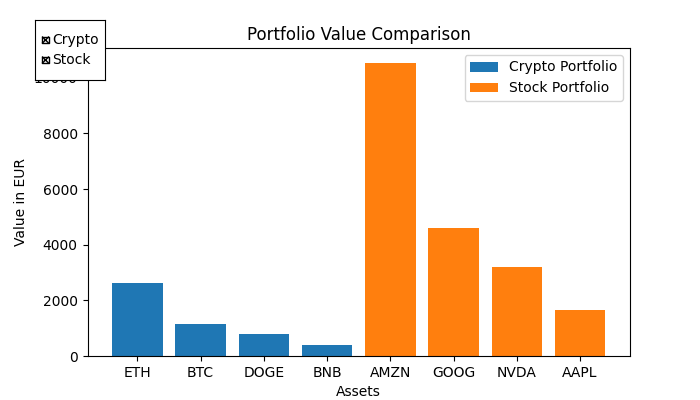

In [17]:
import matplotlib.pyplot as plt
from matplotlib.widgets import CheckButtons

# Enable matplotlib interactive mode in Jupyter Notebook
%matplotlib widget

# Sort the dataframes by value for better readability
df_crypto_assets = df_crypto_assets.sort_values('Value_in_EUR', ascending=False)
df_stock_assets = df_stock_assets.sort_values('Value_in_EUR', ascending=False)

# Create a figure and axis objects
fig, ax = plt.subplots(figsize=(7, 4))

# Plot the initial data (both crypto and stock)
crypto_bars = ax.bar(df_crypto_assets['Asset'], df_crypto_assets['Value_in_EUR'], label='Crypto Portfolio')
stock_bars = ax.bar(df_stock_assets['Asset'], df_stock_assets['Value_in_EUR'], label='Stock Portfolio')

# Set axis labels and title
ax.set_xlabel('Assets')
ax.set_ylabel('Value in EUR')
ax.set_title('Portfolio Value Comparison')

# Add legend
ax.legend()

# Create a checkbox widget
rax = plt.axes([0.05, 0.8, 0.1, 0.15])
check = CheckButtons(rax, ['Crypto', 'Stock'], [True, True])

# Function to handle checkbox toggles
def checkbox_changed(label):
    if label == 'Crypto':
        # Toggle visibility of crypto bars
        for bar in crypto_bars:
            bar.set_visible(not bar.get_visible())
    elif label == 'Stock':
        # Toggle visibility of stock bars
        for bar in stock_bars:
            bar.set_visible(not bar.get_visible())

    # After modifying the visibility of bars, recalculate limits and rescale the view
    ax.relim()
    ax.autoscale_view()

    # Redraw the plot
    plt.draw()

# Register the checkbox function
check.on_clicked(checkbox_changed)

# Show the interactive plot
plt.show()
plt.savefig('flask-black-dashboard/apps/static/assets/img/Crypto_Stock.png')




Iteration 2: The user clicks and deselects that assset class so that a new graph is generated with the left asset classes


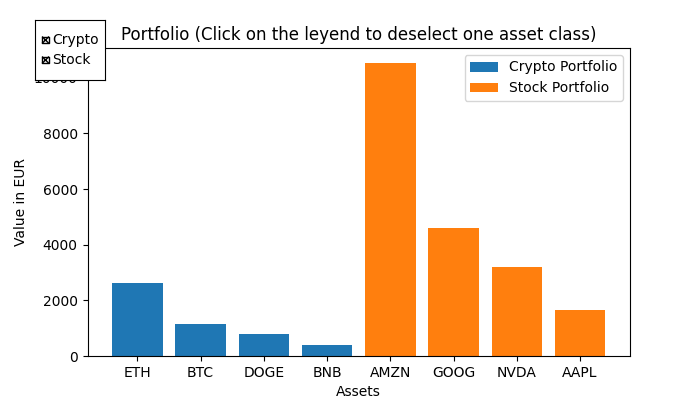

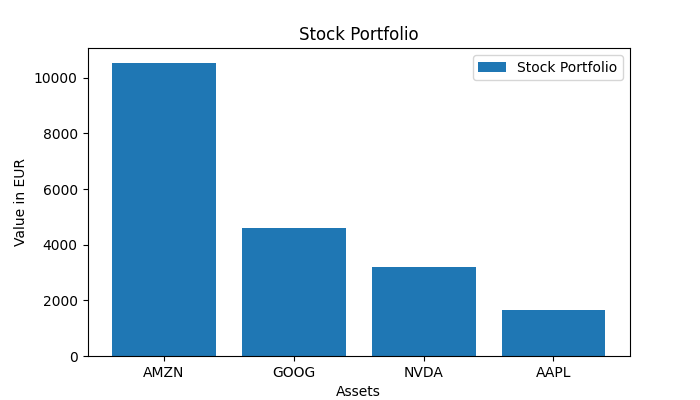

In [18]:
# Enable matplotlib interactive mode in Jupyter Notebook
%matplotlib widget

# Sort the dataframes by value for better readability
df_crypto_assets = df_crypto_assets.sort_values('Value_in_EUR', ascending=False)
df_stock_assets = df_stock_assets.sort_values('Value_in_EUR', ascending=False)

# Create a figure and axis objects
fig, ax = plt.subplots(figsize=(7, 4))

# Plot the initial data (both crypto and stock)
crypto_bars = ax.bar(df_crypto_assets['Asset'], df_crypto_assets['Value_in_EUR'], label='Crypto Portfolio')
stock_bars = ax.bar(df_stock_assets['Asset'], df_stock_assets['Value_in_EUR'], label='Stock Portfolio')

# Set axis labels and title
ax.set_xlabel('Assets')
ax.set_ylabel('Value in EUR')
ax.set_title('Portfolio (Click on the leyend to deselect one asset class)')

# Add legend
ax.legend()

# Create a checkbox widget
rax = plt.axes([0.05, 0.8, 0.1, 0.15])
check = CheckButtons(rax, ['Crypto', 'Stock'], [True, True])

# Function to handle checkbox toggles
def checkbox_changed(label):
    if label == 'Stock':
        # Create a new figure and axes
        fig, ax = plt.subplots(figsize=(7, 4))
        # Plot crypto bars in the new figure
        ax.bar(df_crypto_assets['Asset'], df_crypto_assets['Value_in_EUR'], label='Crypto Portfolio')
        ax.set_xlabel('Assets')
        ax.set_ylabel('Value in EUR')
        ax.set_title('Crypto Portfolio')
        ax.legend()
        plt.show()
        plt.savefig('flask-black-dashboard/apps/static/assets/img/Crypto.png')
    elif label == 'Crypto':
        # Create a new figure and axes
        fig, ax = plt.subplots(figsize=(7, 4))
        # Plot stock bars in the new figure
        ax.bar(df_stock_assets['Asset'], df_stock_assets['Value_in_EUR'], label='Stock Portfolio')
        ax.set_xlabel('Assets')
        ax.set_ylabel('Value in EUR')
        ax.set_title('Stock Portfolio')
        ax.legend()
        plt.show()
        plt.savefig('flask-black-dashboard/apps/static/assets/img/Stock.png')
# Register the checkbox function
check.on_clicked(checkbox_changed)

# Show the interactive plot
plt.show()


Iteration 3: The user clicks on the assset to print the current market price (From APIs)

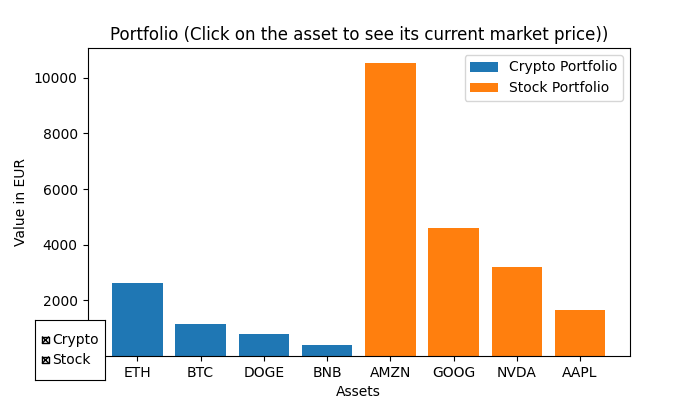

The current price of ETH is 1726.18 €.
The current price of AMZN is 117.55 €.
The current price of GOOG is 111.91 €.
The current price of NVDA is 392.95 €.
The current price of BTC is 27487.95 €.


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import CheckButtons

# Enable matplotlib interactive mode in Jupyter Notebook
%matplotlib widget

# Load the dataframe
# df_stock_assets and df_crypto_assets...

# Concatenate both dataframes
df = pd.concat([df_crypto_assets, df_stock_assets]).set_index('Asset')

# Create a figure and axis objects
fig, ax = plt.subplots(figsize=(7, 4))

# Plot the initial data (both crypto and stock)
crypto_bars = ax.bar(df_crypto_assets['Asset'], df_crypto_assets['Value_in_EUR'], label='Crypto Portfolio')
stock_bars = ax.bar(df_stock_assets['Asset'], df_stock_assets['Value_in_EUR'], label='Stock Portfolio')

# Set axis labels and title
ax.set_xlabel('Assets')
ax.set_ylabel('Value in EUR')
ax.set_title('Portfolio (Click on the asset to see its current market price))')

# Add legend
ax.legend()

# Create a checkbox widget
rax = plt.axes([0.05, 0.05, 0.1, 0.15])
check = CheckButtons(rax, ['Crypto', 'Stock'], [True, True])

# Function to handle checkbox toggles
def checkbox_changed(label):
    if label == 'Crypto':
        # Toggle visibility of crypto bars
        for bar in crypto_bars:
            bar.set_visible(not bar.get_visible())
    elif label == 'Stock':
        # Toggle visibility of stock bars
        for bar in stock_bars:
            bar.set_visible(not bar.get_visible())
    # Redraw the plot
    plt.draw()

# Register the checkbox function
check.on_clicked(checkbox_changed)

# Function to handle click events
def on_click(event):
    for i in range(len(df)):
        if event.inaxes == ax and event.xdata is not None and abs(event.xdata - i) < 0.5:
            asset = df.index[i]
            price = df.loc[asset, 'Price_in_EUR']
            print(f'The current price of {asset} is {round(price,2)} €.')
            break

# Connect the function to the figure
fig.canvas.mpl_connect('button_press_event', on_click)

# Show the interactive plot
plt.show()



Choose a plot type:
1. Week
2. Month


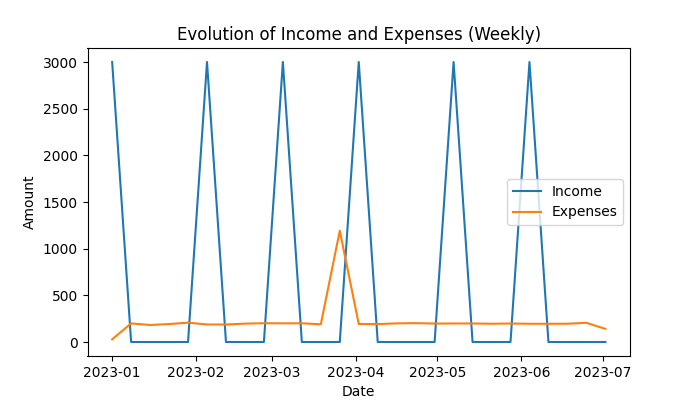

In [15]:
# Interactive plotting
plot_options = ['week', 'month']

while True:
    # Prompt user for plot type
    print("Choose a plot type:")
    for i, option in enumerate(plot_options):
        print(f"{i+1}. {option.capitalize()}")
    choice = input("Enter your choice (1, 2): ")
    if choice.isdigit() and int(choice) in range(1, len(plot_options) + 1):
        break
    print("Invalid choice. Please try again.")

# Calculate the resampled data based on user's choice
choice = int(choice)
if choice == 1:
    resampled_data = df_bank.resample('W').sum()
elif choice == 2:
    resampled_data = df_bank.resample('M').sum()

# Plotting the data
plt.figure(figsize=(7, 4))
plt.plot(resampled_data.index, resampled_data['Income'], label='Income')
plt.plot(resampled_data.index, resampled_data['Total_Expense'], label='Expenses')
plt.xlabel('Date')
plt.ylabel('Amount')
plt.title(f'Evolution of Income and Expenses ({plot_options[choice-1].capitalize()}ly)')
plt.legend()
plt.show()

# Leveraging Flask to build a web dashboard

The Plots avobe have been added as a Png to the Flask Dashboard 

Follow the steps following steps to access the dashboard

Mac OS on the terminal

In [16]:
# virtualenv env
# source env/bin/activate
# pip3 install -r requirements.txt

# export FLASK_APP=run.py
# export FLASK_ENV=development

# flask run

The app runs locally at http://127.0.0.1:5000/

For Windows consult the open source documentation of  

https://github.com/app-generator/flask-volt-dashboard